In [226]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import country_converter as coco

import spacy

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import re

# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

from visualization import *
from tools import *

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)


START_DATE = '2019-12-12'
END_DATE = '2020-04-09'

coronavirus = "coronavirus,covid,covid-19,corona,pandémie,virus, pandemie".lower().split(',')#pandémie,virus

Python version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


## LeTemps.ch

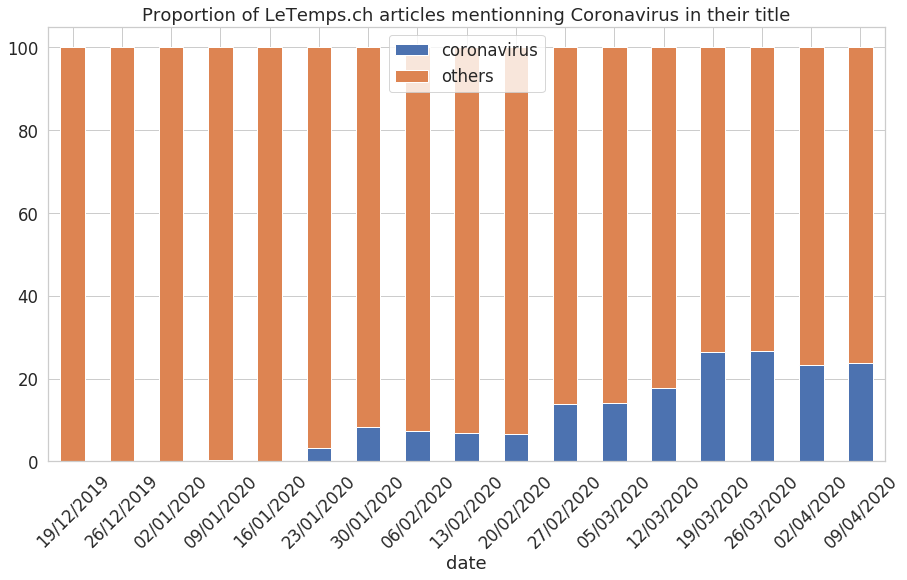

In [231]:
letemps = pd.read_csv("/mnt/datastore/data/medias/letemps.csv")
letemps['date'] = pd.to_datetime(letemps['date'])
letemps = letemps[letemps.date > START_DATE]
letemps = letemps[letemps.date < END_DATE]
letemps = letemps.sort_values(by=['date'])
letemps = letemps.drop_duplicates(subset=['tweet'])

letemps['coronavirus'] =  letemps.title.str.lower().str.contains("|".join(coronavirus))

letemps_percent_covid = letemps.resample('W-THU', on='date').agg({'coronavirus':'sum', 'd':'count'})
letemps_percent_covid.index = letemps_percent_covid.index.strftime("%d/%m/%Y")
letemps_percent_covid['others'] = letemps_percent_covid['d'] - letemps_percent_covid['coronavirus']

# From raw value to percentage
letemps_percent_covid['coronavirus'] = letemps_percent_covid['coronavirus'] / letemps_percent_covid['d'] * 100
letemps_percent_covid['others'] = letemps_percent_covid['others'] / letemps_percent_covid['d'] * 100
 
# plot
letemps_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of LeTemps.ch articles mentionning Coronavirus in their title')
plt.savefig('/home/fanfou/Panorama/figures/Covid_letemps.pdf', bbox_inches='tight')

In [214]:
''' Scrape articles bodies from url
from bs4 import BeautifulSoup
import requests
from tld import get_tld


def extractArticle(urls):
    for url in urls:
        try:
            if get_tld(url, as_object=True).fld != 'letemps.ch':
                continue
        except:
            print("Bad url: ", url)
            continue
        res = requests.get(url)
        soup = BeautifulSoup(res.content, features="lxml")
        try:
            title = soup.find("h1").text
            body = soup.find("div" ,{"class": ["article_body", "content-body", "entry-content"]}).text
            return title, body
        except:
            print(url)

        
    return None, None


# Convert string to list of urls 
letemps.urls = letemps.urls.apply(lambda x: x.strip("[]'").split(','))

letemps['article'] = letemps.urls.apply(extractArticle)
letemps[['title', 'body']] = pd.DataFrame(letemps.article.tolist(), index=letemps.index) 

letemps = pd.read_csv("/mnt/datastore/data/medias/letemps.csv")
'''

'\nfrom bs4 import BeautifulSoup\nimport requests\nfrom tld import get_tld\n\n\ndef extractArticle(urls):\n    for url in urls:\n        try:\n            if get_tld(url, as_object=True).fld != \'letemps.ch\':\n                continue\n        except:\n            print("Bad url: ", url)\n            continue\n        res = requests.get(url)\n        soup = BeautifulSoup(res.content, features="lxml")\n        try:\n            title = soup.find("h1").text\n            body = soup.find("div" ,{"class": ["article_body", "content-body", "entry-content"]}).text\n            return title, body\n        except:\n            print(url)\n\n        \n    return None, None\n\n\n# Convert string to list of urls \nletemps.urls = letemps.urls.apply(lambda x: x.strip("[]\'").split(\',\'))\n\nletemps[\'article\'] = letemps.urls.apply(extractArticle)\nletemps[[\'title\', \'body\']] = pd.DataFrame(letemps.article.tolist(), index=letemps.index) \n\nletemps = pd.read_csv("/mnt/datastore/data/medias/lete

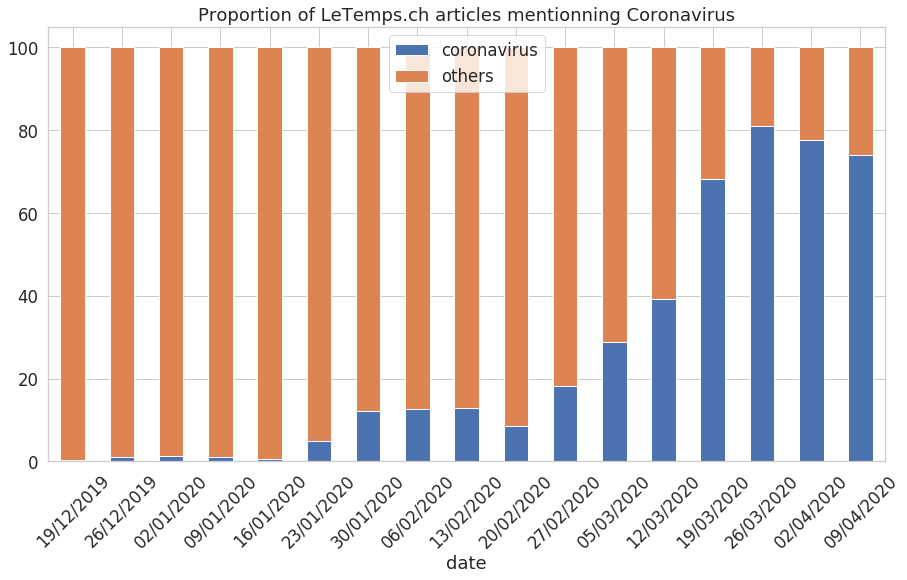

In [232]:

letemps['coronavirus'] =  letemps.body.str.lower().str.contains("|".join(coronavirus))

letemps_percent_covid = letemps.resample('W-THU', on='date').agg({'coronavirus':'sum', 'd':'count'})
letemps_percent_covid['others'] = letemps_percent_covid['d'] - letemps_percent_covid['coronavirus']
letemps_percent_covid.index = letemps_percent_covid.index.strftime("%d/%m/%Y")
# From raw value to percentage
letemps_percent_covid['coronavirus'] = letemps_percent_covid['coronavirus'] / letemps_percent_covid['d'] * 100
letemps_percent_covid['others'] = letemps_percent_covid['others'] / letemps_percent_covid['d'] * 100
 
# plot
letemps_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Proportion of LeTemps.ch articles mentionning Coronavirus')
plt.xticks(rotation=45)
plt.show()

## 20Minutes.ch

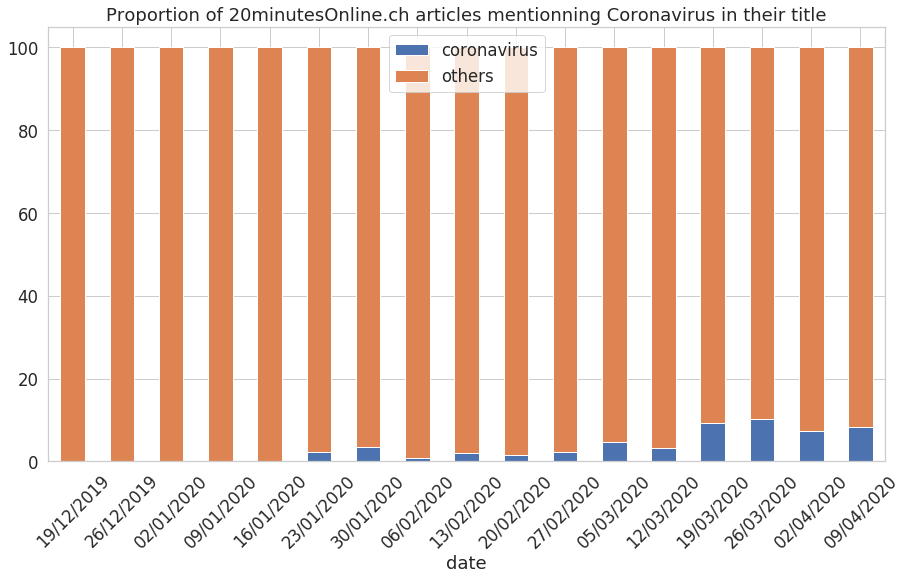

In [257]:
_20minOnline = pd.read_csv("/mnt/datastore/data/medias/20minutesOnline.csv")
_20minOnline['coronavirus'] =  _20minOnline.title.str.lower().str.contains("|".join(coronavirus))
_20minOnline['date'] = pd.to_datetime(_20minOnline['date'])
_20minOnline = _20minOnline[_20minOnline.date > START_DATE]
_20minOnline = _20minOnline[_20minOnline.date < END_DATE]
_20minOnline = _20minOnline.sort_values(by=['date'])
_20minOnline = _20minOnline.drop_duplicates(subset=['tweet'])

_20minOnline_percent_covid = _20minOnline.resample('W-THU', on='date').agg({'coronavirus':'sum', 'id':'count'})
_20minOnline_percent_covid['others'] = _20minOnline_percent_covid['id'] - _20minOnline_percent_covid['coronavirus']
_20minOnline_percent_covid.index = _20minOnline_percent_covid.index.strftime("%d/%m/%Y")

# From raw value to percentage
_20minOnline_percent_covid['coronavirus'] = _20minOnline_percent_covid['coronavirus'] / _20minOnline_percent_covid['id'] * 100
_20minOnline_percent_covid['others'] = _20minOnline_percent_covid['others'] / _20minOnline_percent_covid['id'] * 100
 
# plot
_20minOnline_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of 20minutesOnline.ch articles mentionning Coronavirus in their title')
plt.savefig('/home/fanfou/Panorama/figures/Covid_20minutes.pdf', bbox_inches='tight')

In [261]:
'''
from bs4 import BeautifulSoup
import requests
from tld import get_tld


def extractArticle(urls):
    for url in urls:
        try:
            if get_tld(url, as_object=True).fld != '20min.ch':
                continue
        except:
            print("Bad url: ", url)
            continue
        res = requests.get(url)
        soup = BeautifulSoup(res.content, features="lxml")
        try:
            title = soup.find("h1").text
            body = soup.find("div" ,{"class": ["story_text"]}).text
            return title, body
        except:
            print(url)

        
    return None, None


# Convert string to list of urls 
_20minOnline.urls = _20minOnline.urls.apply(lambda x: x.strip("[]'").split(','))

_20minOnline['article'] = _20minOnline.urls.apply(extractArticle)
_20minOnline[['title', 'body']] = pd.DataFrame(_20minOnline.article.tolist(), index=_20minOnline.index) 
_20minOnline.head()
#_20minOnline = pd.read_csv("/mnt/datastore/data/medias/letemps.csv")
'''

'\nfrom bs4 import BeautifulSoup\nimport requests\nfrom tld import get_tld\n\n\ndef extractArticle(urls):\n    for url in urls:\n        try:\n            if get_tld(url, as_object=True).fld != \'20min.ch\':\n                continue\n        except:\n            print("Bad url: ", url)\n            continue\n        res = requests.get(url)\n        soup = BeautifulSoup(res.content, features="lxml")\n        try:\n            title = soup.find("h1").text\n            body = soup.find("div" ,{"class": ["story_text"]}).text\n            return title, body\n        except:\n            print(url)\n\n        \n    return None, None\n\n\n# Convert string to list of urls \n_20minOnline.urls = _20minOnline.urls.apply(lambda x: x.strip("[]\'").split(\',\'))\n\n_20minOnline[\'article\'] = _20minOnline.urls.apply(extractArticle)\n_20minOnline[[\'title\', \'body\']] = pd.DataFrame(_20minOnline.article.tolist(), index=_20minOnline.index) \n_20minOnline.head()\n#_20minOnline = pd.read_csv("/mnt/dat

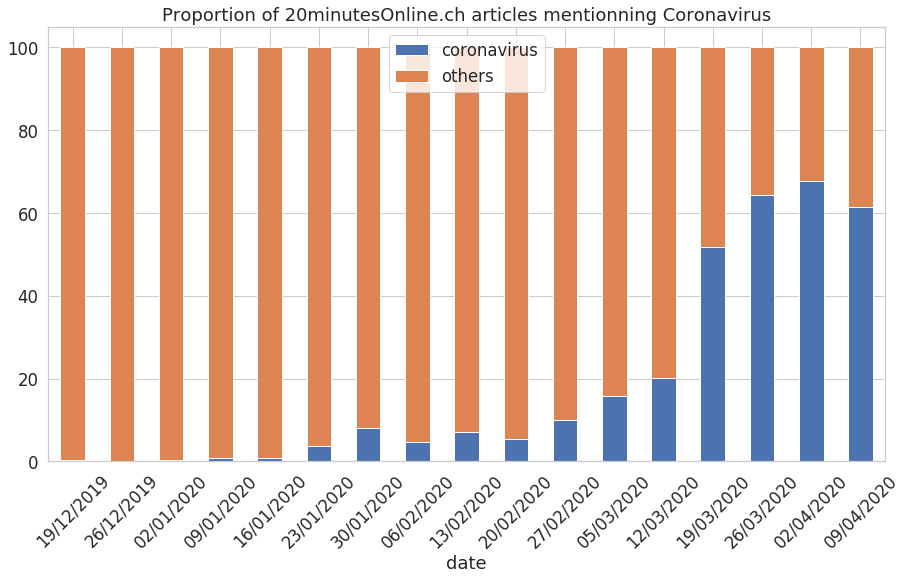

In [259]:
_20minOnline['coronavirus'] =  _20minOnline.body.str.lower().str.contains("|".join(coronavirus))
_20minOnline_percent_covid = _20minOnline.resample('W-THU', on='date').agg({'coronavirus':'sum', 'id':'count'})
_20minOnline_percent_covid['others'] = _20minOnline_percent_covid['id'] - _20minOnline_percent_covid['coronavirus']
_20minOnline_percent_covid.index = _20minOnline_percent_covid.index.strftime("%d/%m/%Y")

# From raw value to percentage
_20minOnline_percent_covid['coronavirus'] = _20minOnline_percent_covid['coronavirus'] / _20minOnline_percent_covid['id'] * 100
_20minOnline_percent_covid['others'] = _20minOnline_percent_covid['others'] / _20minOnline_percent_covid['id'] * 100
 
# plot
_20minOnline_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of 20minutesOnline.ch articles mentionning Coronavirus')
plt.show()

## LesObservateurs.ch

Text(0.5, 1.0, 'Proportion of LesObservateurs.ch articles mentionning Coronavirus in their title')

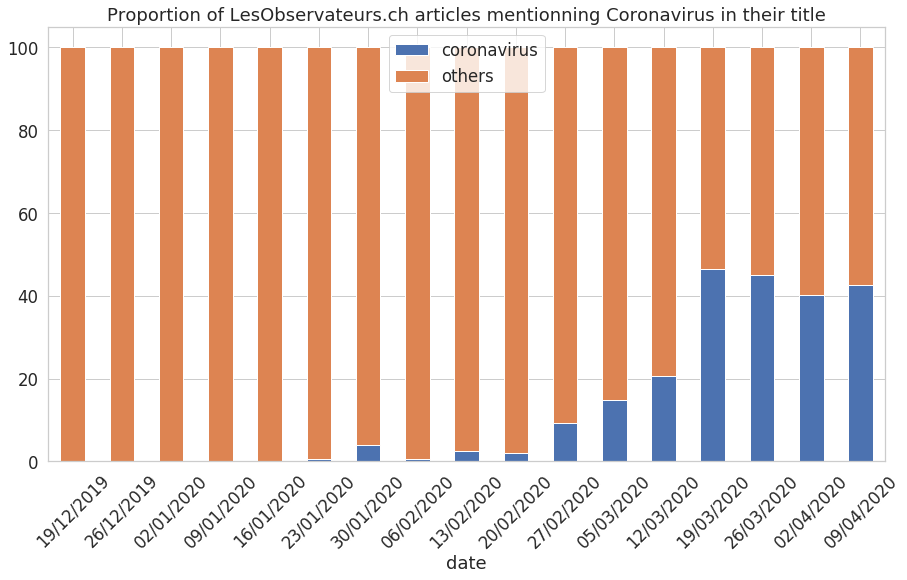

In [234]:
lesObservateurs = pd.read_csv("/mnt/datastore/data/medias/lesobservateurs.csv");
lesObservateurs['date'] = pd.to_datetime(lesObservateurs['date'])
lesObservateurs = lesObservateurs[lesObservateurs.date > START_DATE]
lesObservateurs = lesObservateurs[lesObservateurs.date < END_DATE]
lesObservateurs = lesObservateurs.sort_values(by=['date'])
lesObservateurs = lesObservateurs.drop_duplicates(subset=['id'])

lesObservateurs['coronavirus'] =  lesObservateurs.title.str.lower().str.contains("|".join(coronavirus))

lesObservateurs_percent_covid = lesObservateurs.resample('W-THU', on='date').agg({'coronavirus':'sum', 'id':'count'})
lesObservateurs_percent_covid['others'] = lesObservateurs_percent_covid['id'] - lesObservateurs_percent_covid['coronavirus']
lesObservateurs_percent_covid.index = lesObservateurs_percent_covid.index.strftime("%d/%m/%Y")
# From raw value to percentage
lesObservateurs_percent_covid['coronavirus'] = lesObservateurs_percent_covid['coronavirus'] / lesObservateurs_percent_covid['id'] * 100
lesObservateurs_percent_covid['others'] = lesObservateurs_percent_covid['others'] / lesObservateurs_percent_covid['id'] * 100
 
# plot
lesObservateurs_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of LesObservateurs.ch articles mentionning Coronavirus in their title')
#plt.savefig('/home/fanfou/Panorama/figures/Covid_lesobservateurs.pdf', bbox_inches='tight')

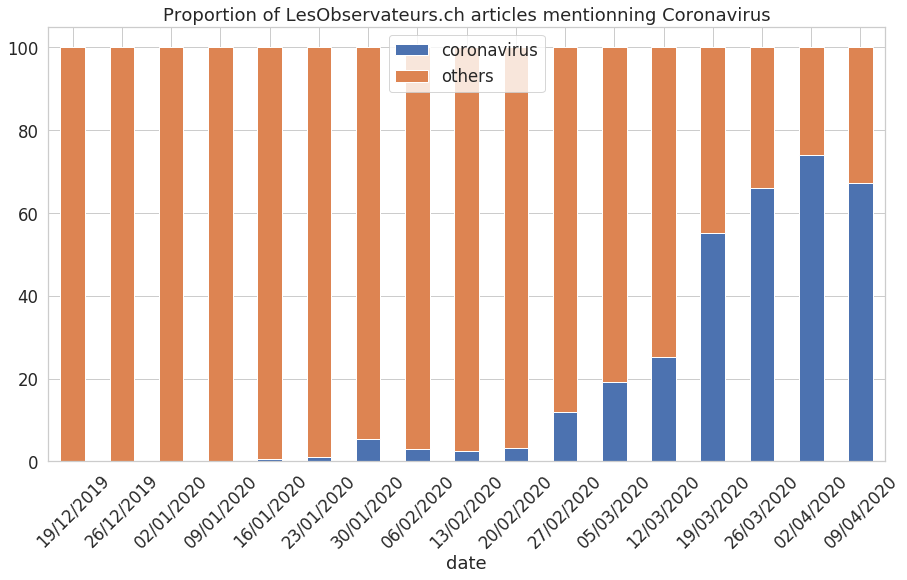

In [236]:
lesObservateurs['coronavirus'] =  lesObservateurs.body.str.lower().str.contains("|".join(coronavirus))

lesObservateurs_percent_covid = lesObservateurs.resample('W-THU', on='date').agg({'coronavirus':'sum', 'id':'count'})
lesObservateurs_percent_covid['others'] = lesObservateurs_percent_covid['id'] - lesObservateurs_percent_covid['coronavirus']
lesObservateurs_percent_covid.index = lesObservateurs_percent_covid.index.strftime("%d/%m/%Y")
# From raw value to percentage
lesObservateurs_percent_covid['coronavirus'] = lesObservateurs_percent_covid['coronavirus'] / lesObservateurs_percent_covid['id'] * 100
lesObservateurs_percent_covid['others'] = lesObservateurs_percent_covid['others'] / lesObservateurs_percent_covid['id'] * 100
 
# plot
lesObservateurs_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of LesObservateurs.ch articles mentionning Coronavirus')
plt.savefig('/home/fanfou/Panorama/figures/Covid_lesobservateurs.pdf', bbox_inches='tight')

## NZZ

In [210]:
'''
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
nzz_articles = spark.read.json("/mnt/datastore/data/medias/nzz/*.json").toPandas()
nzz_articles = nzz_articles.drop_duplicates(subset=['id'])
nzz_articles['date'] = pd.to_datetime(nzz_articles['date'])
nzz_articles = nzz_articles[nzz_articles.date > START_DATE]
nzz_articles = nzz_articles[nzz_articles.date < END_DATE]
nzz_articles = nzz_articles.sort_values(by=['date'])
nzz_articles.to_csv("/mnt/datastore/data/medias/nzz.csv")
'''

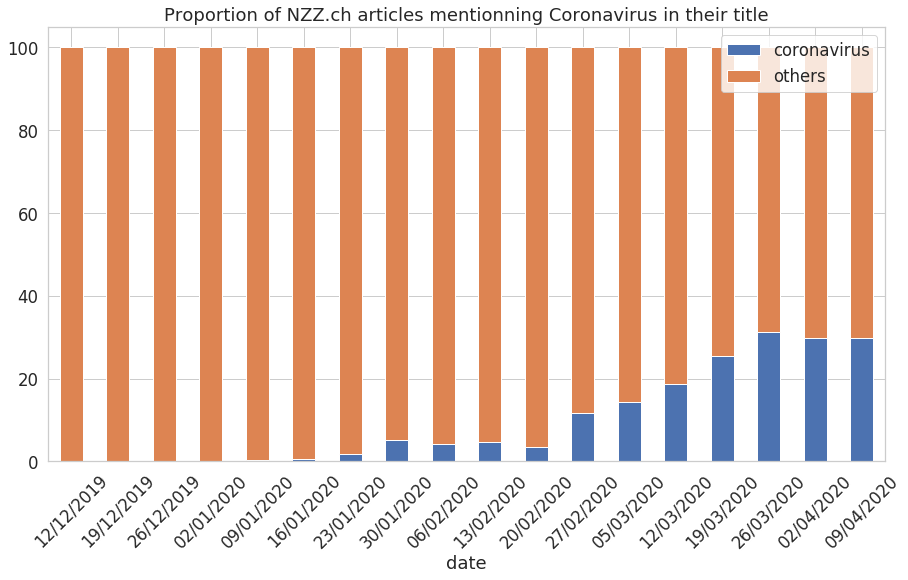

In [237]:
nzz_articles = pd.read_csv("/mnt/datastore/data/medias/nzz.csv")
nzz_articles['date'] = pd.to_datetime(nzz_articles['date'])
nzz_articles = nzz_articles[nzz_articles.date > START_DATE]
nzz_articles = nzz_articles[nzz_articles.date < END_DATE]
nzz_articles = nzz_articles.sort_values(by=['date'])

nzz_articles['coronavirus'] =  nzz_articles.title.str.lower().str.contains("|".join(coronavirus))

nzz_percent_covid = nzz_articles.resample('W-THU', on='date').agg({'coronavirus':'sum', 'id':'count'})
nzz_percent_covid['others'] = nzz_percent_covid['id'] - nzz_percent_covid['coronavirus']
nzz_percent_covid.index = nzz_percent_covid.index.strftime("%d/%m/%Y")
# From raw value to percentage
nzz_percent_covid['coronavirus'] = nzz_percent_covid['coronavirus'] / nzz_percent_covid['id'] * 100
nzz_percent_covid['others'] = nzz_percent_covid['others'] / nzz_percent_covid['id'] * 100
 
# plot
nzz_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of NZZ.ch articles mentionning Coronavirus in their title')
plt.show()

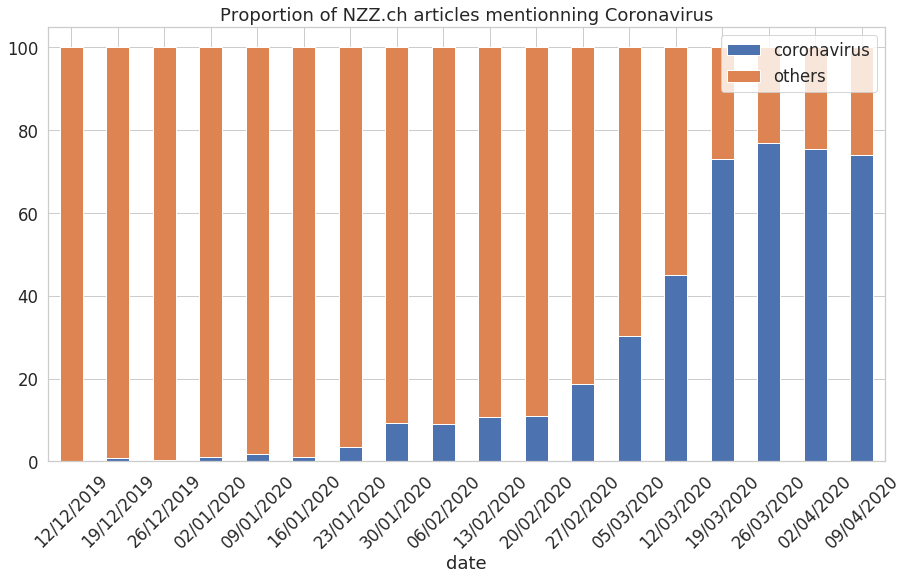

In [238]:
nzz_articles['coronavirus'] =  nzz_articles.body.str.lower().str.contains("|".join(coronavirus))

nzz_percent_covid = nzz_articles.resample('W-THU', on='date').agg({'coronavirus':'sum', 'id':'count'})
nzz_percent_covid['others'] = nzz_percent_covid['id'] - nzz_percent_covid['coronavirus']
nzz_percent_covid.index = nzz_percent_covid.index.strftime("%d/%m/%Y")
# From raw value to percentage
nzz_percent_covid['coronavirus'] = nzz_percent_covid['coronavirus'] / nzz_percent_covid['id'] * 100
nzz_percent_covid['others'] = nzz_percent_covid['others'] / nzz_percent_covid['id'] * 100
 
# plot
nzz_percent_covid[['coronavirus','others']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Proportion of NZZ.ch articles mentionning Coronavirus')
plt.show()

## Putting everything together

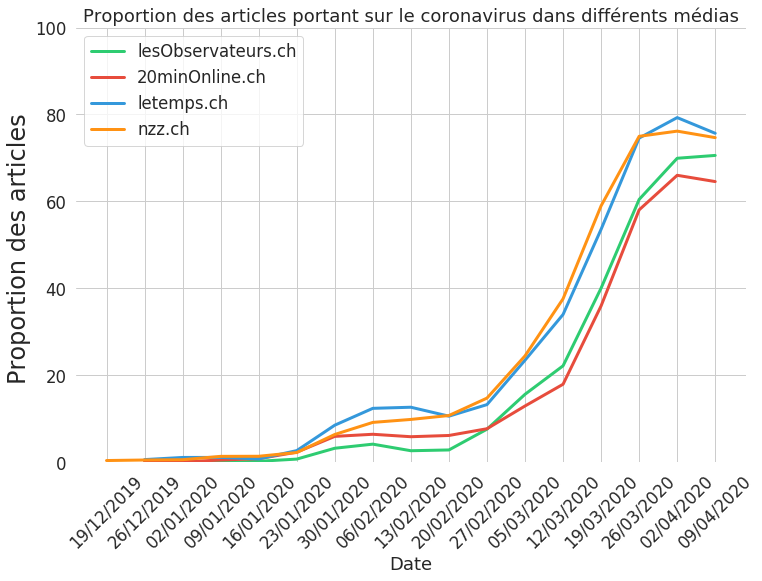

In [260]:
import datetime
blue_col   = "#3498db"
red_col    = "#e74c3c"
green_col  = "#2ecc71"
orange_col = "#ff9214"

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

sns_cmap = sns.light_palette("Navy", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(lesObservateurs_percent_covid.index,
        lesObservateurs_percent_covid['coronavirus'].rolling(window=2).mean(),
        '-',
        color=green_col, label="lesObservateurs.ch", marker='',linewidth=3.0)

ax.plot(_20minOnline_percent_covid.index,
        _20minOnline_percent_covid['coronavirus'].rolling(window=2).mean(),
        '-',
        color=red_col, label="20minOnline.ch", marker='',linewidth=3.0)

ax.plot(letemps_percent_covid.index,
        letemps_percent_covid['coronavirus'].rolling(window=2).mean(),
        '-',
        color=blue_col, label="letemps.ch", marker='',linewidth=3.0)

ax.plot(nzz_percent_covid.index,
        nzz_percent_covid['coronavirus'].rolling(window=2).mean(),
        '-',
        color=orange_col, label="nzz.ch", marker='',linewidth=3.0)


ax.set_ylabel('Proportion des articles ', fontsize=24)
ax.set(xlabel="Date",title="Proportion des articles portant sur le coronavirus dans différents médias")

plt.legend()

plt.ylim([0, 100])

# Format the x axis
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
#ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

#ax.grid(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xticks(rotation=45)

plt.show()